In [33]:
import sys
sys.path.append("..")

import json

from pathlib import Path
from collections import defaultdict
# from src.graph.load_gfa import load_gfa
from src.graph.info_from_gfa import load_info_graph
from src.utils.params_from_path import params_from_path
from src.utils.info_from_exp import get_info_from_exp

import seaborn as sns
import seaborn.objects as so
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(rc = {'figure.figsize':(10,8)})

In [34]:
NSEQS = 20
NAME = f"{NSEQS}-SARS-CoV2-MSA"
PATH_SAVE = Path(f"../output-experiments-paper/sars-cov-2-{NSEQS}-row_maximal-vs-complete-not_alpha_consistent/")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

ALPHA_BY_SEQS = {
    20: 759,
    50: 243,
}

In [35]:
OBJ_FUNCTIONS = ["blocks", "weighted", "depth", "strings","pen_strings"]
ALPHAS = [ALPHA_BY_SEQS[NSEQS]]
MIN_LEN = [0, 20]
MIN_COVERAGE = [0.0, 0.3]
ALPHA_LABELS = [ f"{chr(945)}={alpha}" for alpha in ALPHAS]
DECOMPOSITIONS = ["row-maximal", "complete"]

### Other tools

#### `pggb` and `vg`

In [36]:
path_pggb = list(Path(f"../experiments/pggb/sars-cov-2/{NAME}").rglob("*.gfa"))[0]
info_pggb = load_info_graph(path_pggb)
info_pggb

{'n_vertices': 691,
 'n_edges': 944,
 'len_graph': 40561,
 'potential_seeds_len15': 36161,
 'potential_seeds_len20': 34891,
 'potential_seeds_len25': 33672,
 'nodes_depth_gt_011': 0.7018813314037626,
 'nodes_depth_gt_015': 0.7018813314037626,
 'nodes_depth_gt_02': 0.6888567293777135,
 'nodes_depth_gt_025': 0.6555716353111433,
 'nodes_depth_gt_03': 0.6512301013024602}

In [37]:
path_vg = Path(f"../experiments/vg/sars-cov-2/{NAME}.gfa")
info_vg =  load_info_graph(path_vg) 
info_vg

{'n_vertices': 698,
 'n_edges': 948,
 'len_graph': 37149,
 'potential_seeds_len15': 32515,
 'potential_seeds_len20': 31194,
 'potential_seeds_len25': 29935,
 'nodes_depth_gt_011': 0.7220630372492837,
 'nodes_depth_gt_015': 0.7220630372492837,
 'nodes_depth_gt_02': 0.7034383954154728,
 'nodes_depth_gt_025': 0.664756446991404,
 'nodes_depth_gt_03': 0.6575931232091691}

## `row-maximal` vs `complete` decompositions

In [38]:
# path to folders with each decomposition
path_complete = f"../experiments-decompositions/sars-cov-2-{NSEQS}-complete-not_alpha_consistent-not_fixblock/"
path_rowmaximal= f"../experiments-decompositions/sars-cov-2-{NSEQS}-row_maximal-not_alpha_consistent-not_fixblock/"

In [39]:
df_graphs = pd.concat([
    get_info_from_exp(path_complete, name=NAME), 
    get_info_from_exp(path_rowmaximal, name=NAME)
    ], ignore_index=True)
df_graphs["objective_function"] = df_graphs["objective_function"].apply(lambda x: "blocks" if x=="nodes" else x)
df_graphs["objective_function"] = df_graphs["objective_function"].apply(lambda x: "pen_strings" if x=="depth_and_len" else x)

In [40]:
df_graphs.alpha.describe()

count    270.000000
mean     273.533333
std      210.696307
min        1.000000
25%       98.000000
50%      221.000000
75%      334.000000
max      759.000000
Name: alpha, dtype: float64

In [41]:
# data frame to plot
df_graphs_plot = df_graphs.query(
    f"""alpha in {tuple(ALPHAS)} and min_coverage in {MIN_COVERAGE} and min_len in {MIN_LEN}""" #) # or (objective_function == 'weighted' and min_len in {MIN_LEN}) or (objective_function == 'weighted' and min_coverage in {MIN_COVERAGE})"""
    ).copy()
df_graphs_plot["alpha_label"] = df_graphs_plot["alpha"].apply(lambda x: f"{chr(945)}={x}")

df_graphs_plot.head()

objective_function  penalization  min_coverage  min_len  alpha  \
6                depth          1000           0.3        0    759   
34             strings             0           0.0        0    759   
94            weighted          1000           0.0       20    759   
113             blocks             0           0.0        0    759   
126        pen_strings             0           0.0        0    759   

     alpha_consistent decomposition  \
6               False      complete   
34              False      complete   
94              False      complete   
113             False      complete   
126             False      complete   

                                                  path  n_vertices  n_edges  \
6    ../experiments-decompositions/sars-cov-2-20-co...         659      894   
34   ../experiments-decompositions/sars-cov-2-20-co...         698      948   
94   ../experiments-decompositions/sars-cov-2-20-co...         246      357   
113  ../experiments-decompositions/sars-cov-2-20-co...         231      335   
126  ../experiments-decompositions/sars-cov-2-20-co...         698      948   

     len_graph  potential_seeds_len15  potential_seeds_len20  \
6        41030                  36391                  35016   
34       37149                  32515                  31194   
94      273299                 270052                 268912   
113     275730                 272774                 271759   
126      37149                  32515                  31194   

     potential_seeds_len25  nodes_depth_gt_011  nodes_depth_gt_015  \
6                    33691            0.702580            0.702580   
34                   29935            0.722063            0.722063   
94                  267772            0.317073            0.317073   
113                 270744            0.298701            0.298701   
126                  29935            0.722063            0.722063   

     nodes_depth_gt_02  nodes_depth_gt_025  nodes_depth_gt_03 alpha_label  
6             0.687405            0.650986           0.649469       α=759  
34            0.703438            0.664756           0.657593       α=759  
94            0.219512            0.170732           0.154472       α=759  
113           0.203463            0.151515           0.121212       α=759  
126           0.703438            0.664756           0.657593       α=759

In [42]:
LEGEND = True
## Fontsizes plots
FONTSIZE_TITLE = 18
FONTSIZE_SUBTITLE = 16
FONTSIZE_X = 16
FONTSIZE_Y = 16
FONTSIZE_TOOLS = 14 

FONTSIZE_GRID_TITLE = 18
FONTSIZE_GRID_SUBTITLE = 16
FONTSIZE_GRID_X = 16
FONTSIZE_GRID_Y = 16
FONTSIZE_GRID_TOOLS = 14 


In [43]:

# xpos_pggb = int(df_graphs_plot.alpha.max()*1.05)
# xpos_vg   = int(df_graphs_plot.alpha.max()*1.05)
# g_nodes_split = sns.relplot(data=df_graphs_plot, x="objective_function", 
#             y=feature, 
#             col="alpha", 
#             kind="scatter", 
#             hue="decomposition",
#             style="decomposition",
#             markers=["^","o"],
#             col_order = ALPHA,
#             legend=LEGEND,
#             )
# g_nodes_split.set(ylim=(ymin,ymax))

# # # g_nodes_split.fig.text(x=0.5, y=1.1, s=f'{NAME} | Number of nodes w.r.t. {chr(945)}', fontsize=FONTSIZE_GRID_TITLE, weight='bold', ha='center', va='bottom', )
# # # g_nodes_split.fig.text(x=0.5, y=1.05, s=f'Complete vs Row-maximal decomposition | not-{chr(945)}-consistent', fontsize=FONTSIZE_GRID_SUBTITLE, alpha=0.75, ha='center', va='bottom', )

# # # add pggb
# g_nodes_split.refline(y=info_pggb[feature], linestyle="dashed", color="black", label= "pggb")
# ax = g_nodes_split.fig.axes[-1]
# ax.text(x=4.2, y=info_pggb[feature]*0.994, s='pggb', fontsize=FONTSIZE_GRID_TOOLS, color="black")

# # # add vg
# g_nodes_split.refline(y=info_vg[feature], linestyle="dotted", color="red", label= "vg")
# ax = g_nodes_split.fig.axes[-1]
# ax.text(x=4.2, y=info_vg[feature]*1.006, s='vg', fontsize=FONTSIZE_GRID_TOOLS, color="red")

# for ax,alpha_label in zip(g_nodes_split.fig.axes,ALPHA_LABELS): 
#     ax.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
#     ax.set_ylabel("Number of vertices", fontdict=dict(fontsize=FONTSIZE_GRID_X))
#     ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)

# sns.move_legend(
#     g_nodes_split, "lower center",
#     bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
# )
# plt.tight_layout()
# # g_nodes_split.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}-facetgrid.png"),dpi=300)

### Number of vertices

In [44]:
feature = "n_vertices"

# min and max y-axis values
feat_min = min(df_graphs_plot[feature].min(), info_pggb[feature], info_vg[feature])
feat_max = max(df_graphs_plot[feature].max(), info_pggb[feature], info_vg[feature])
delta_range = feat_max - feat_min
ymin = feat_min - 0.1*delta_range 
ymax = feat_max + 0.1*delta_range

ymin, ymax


(184.3, 744.7)

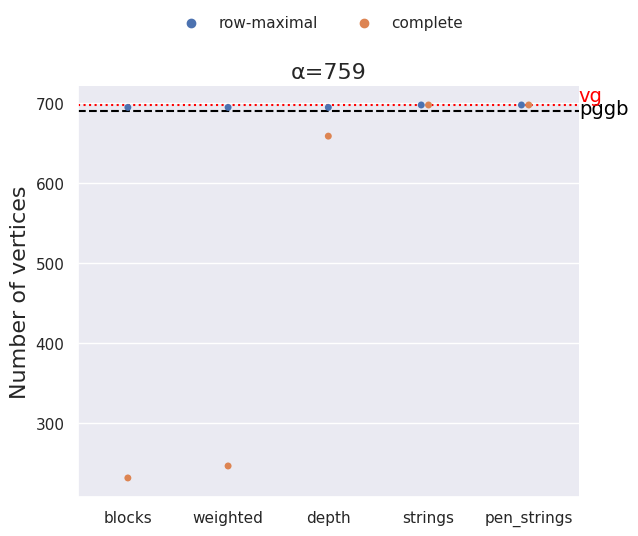

In [45]:
g_nodes = sns.catplot(
    data=df_graphs_plot, kind="swarm",
    x="objective_function", y=feature, 
    col="alpha", 
    hue="decomposition",
    # aspect=.8,
    order=OBJ_FUNCTIONS,
    hue_order=DECOMPOSITIONS,
)

g_nodes.refline(y=info_pggb[feature], linestyle="dashed", color="black", label= "pggb")
ax = g_nodes.fig.axes[-1]
ax.text(x=4.5, y=info_pggb[feature]*0.994, s='pggb', fontsize=FONTSIZE_GRID_TOOLS, color="black")

# # add vg
g_nodes.refline(y=info_vg[feature], linestyle="dotted", color="red", label= "vg")
ax = g_nodes.fig.axes[-1]
ax.text(x=4.5, y=info_vg[feature]*1.006, s='vg', fontsize=FONTSIZE_GRID_TOOLS, color="red")

for ax,alpha_label in zip(g_nodes.fig.axes,ALPHA_LABELS): 
    ax.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_ylabel("Number of vertices", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)

sns.move_legend(
    g_nodes, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)
plt.tight_layout()

g_nodes.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)

### Length of the graph

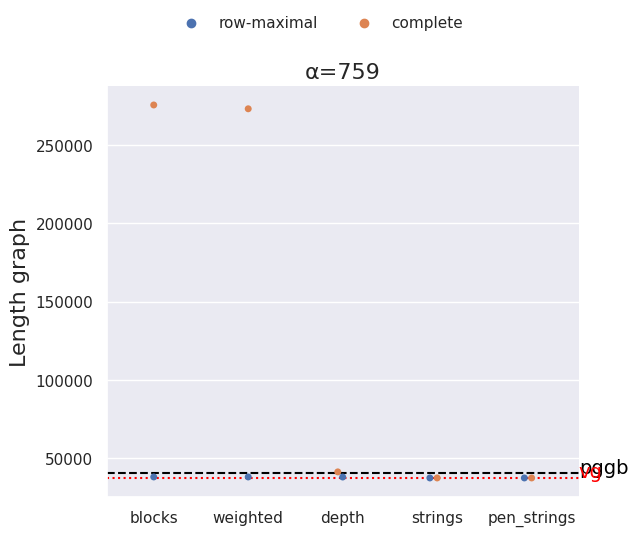

In [46]:
feature = "len_graph"

g_len_graph = sns.catplot(
    data=df_graphs_plot, kind="swarm",
    x="objective_function", y=feature, 
    col="alpha", 
    hue="decomposition",
    # aspect=.8,
    order=OBJ_FUNCTIONS,
    hue_order=DECOMPOSITIONS,
)

g_len_graph.refline(y=info_pggb[feature], linestyle="dashed", color="black", label= "pggb")
ax = g_len_graph.fig.axes[-1]
ax.text(x=4.5, y=info_pggb[feature]*0.994, s='pggb', fontsize=FONTSIZE_GRID_TOOLS, color="black")

# # add vg
g_len_graph.refline(y=info_vg[feature], linestyle="dotted", color="red", label= "vg")
ax = g_len_graph.fig.axes[-1]
ax.text(x=4.5, y=info_vg[feature]*1.006, s='vg', fontsize=FONTSIZE_GRID_TOOLS, color="red")

for ax,alpha_label in zip(g_len_graph.fig.axes,ALPHA_LABELS): 
    ax.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_ylabel("Length graph", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)

sns.move_legend(
    g_len_graph, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)
plt.tight_layout()
g_len_graph.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)

### Seeds

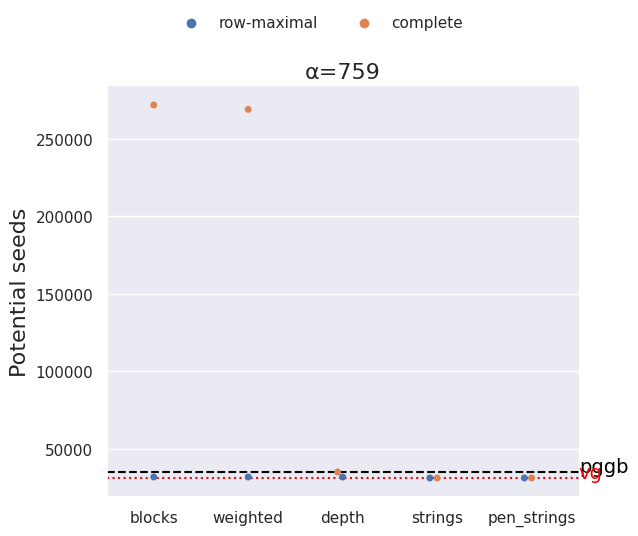

In [47]:
feature = "potential_seeds_len20"

g_seeds = sns.catplot(
    data=df_graphs_plot, kind="swarm",
    x="objective_function", y=feature, 
    col="alpha", 
    hue="decomposition",
    # aspect=.8,
    order=OBJ_FUNCTIONS,
    hue_order=DECOMPOSITIONS,
)

g_seeds.refline(y=info_pggb[feature], linestyle="dashed", color="black", label= "pggb")
ax = g_seeds.fig.axes[-1]
ax.text(x=4.5, y=info_pggb[feature]*0.994, s='pggb', fontsize=FONTSIZE_GRID_TOOLS, color="black")

# # add vg
g_seeds.refline(y=info_vg[feature], linestyle="dotted", color="red", label= "vg")
ax = g_seeds.fig.axes[-1]
ax.text(x=4.5, y=info_vg[feature]*1.006, s='vg', fontsize=FONTSIZE_GRID_TOOLS, color="red")

for ax,alpha_label in zip(g_seeds.fig.axes,ALPHA_LABELS): 
    ax.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_ylabel("Potential seeds", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)

sns.move_legend(
    g_seeds, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)
plt.tight_layout()

g_seeds.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)

### Node Coverage

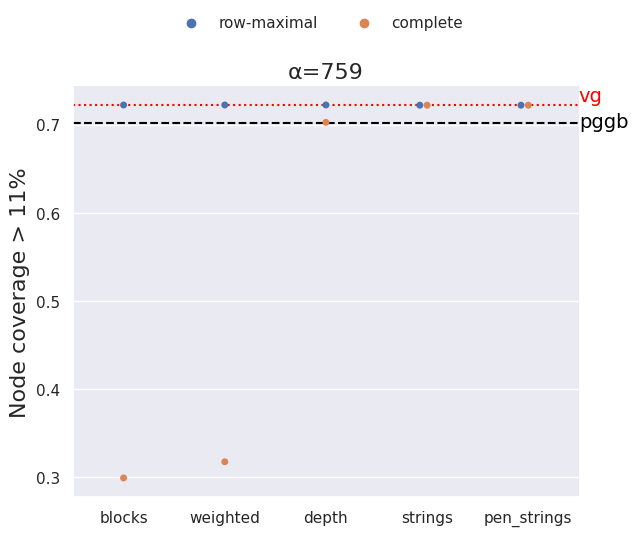

In [48]:
feature="nodes_depth_gt_011"

g_depth = sns.catplot(
    data=df_graphs_plot, kind="swarm",
    x="objective_function", y=feature, 
    col="alpha", 
    hue="decomposition",
    # aspect=.8,
    order=OBJ_FUNCTIONS,
    hue_order=DECOMPOSITIONS,
)

g_depth.refline(y=info_pggb[feature], linestyle="dashed", color="black", label= "pggb")
ax = g_depth.fig.axes[-1]
ax.text(x=4.5, y=info_pggb[feature]*0.994, s='pggb', fontsize=FONTSIZE_GRID_TOOLS, color="black")

# # add vg
g_depth.refline(y=info_vg[feature], linestyle="dotted", color="red", label= "vg")
ax = g_depth.fig.axes[-1]
ax.text(x=4.5, y=info_vg[feature]*1.006, s='vg', fontsize=FONTSIZE_GRID_TOOLS, color="red")

for ax,alpha_label in zip(g_depth.fig.axes,ALPHA_LABELS): 
    ax.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_ylabel("Node coverage > 11%", fontdict=dict(fontsize=FONTSIZE_GRID_X))
    ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)

sns.move_legend(
    g_depth, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)
plt.tight_layout()
g_depth.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)